# Kanapy
## Analysis of EBSD maps and generation of voxelated RVE

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
August 2022

### 1. Prepare system settings

In [1]:
import kanapy as knpy
from math import pi

if not knpy.MTEX_AVAIL:
    raise ModuleNotFoundError('Anaysis of EBSD maps is only possible with an '+\
                              'existing MTEX installation in Matlab.')

### 2. Analyse EBSD map with MTEX module and obtain statistical information

<img alt="EBSD map 316L" src="./ebsd_316L_experiment.png">
<img src="./IPFkey.png" alt="IPF key" style="width:200px">


I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 

 ebsd = EBSD.load(fileName,'convertSpatial2EulerReferenceFrame','setting 2')
> In loadEBSD_ang (line 210)
In EBSD.load (line 86)
  I'm going to colorize the orientation data with the 
  standard MTEX ipf colorkey. To view the colorkey do:
 
  ipfKey = ipfColorKey(ori_variable_name)
  plot(ipfKey)


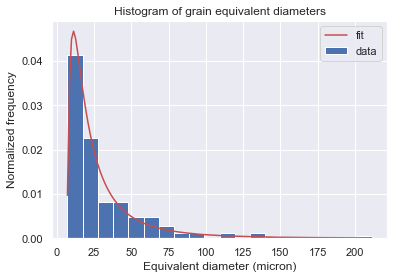

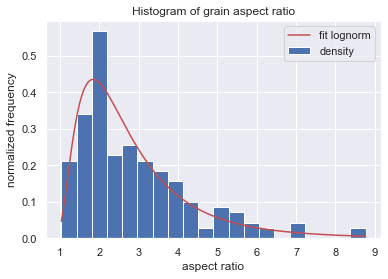

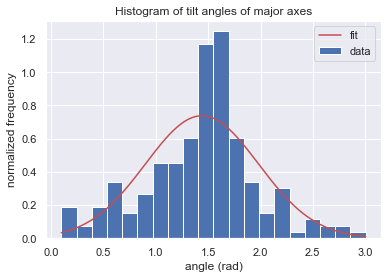

Analyzed microstructure with 182 grains.
Average grain size = 14.123 micron, average aspect ratio = 1.69,         average tilt angle = 82.551°


In [5]:
fname = 'ebsd_316L_500x500.ang'  # name of ang file to be imported
matname = 'Iron fcc'  # material name for MTEX
matnumber = 4         # material number of austenite in CP UMAT

# read EBSD map and evaluate statistics of microstructural features
ebsd = knpy.EBSDmap(fname, matname)


### 3. Pack ellipsoids and generate voxelized RVE

Generating particle distribution based on user defined statistics


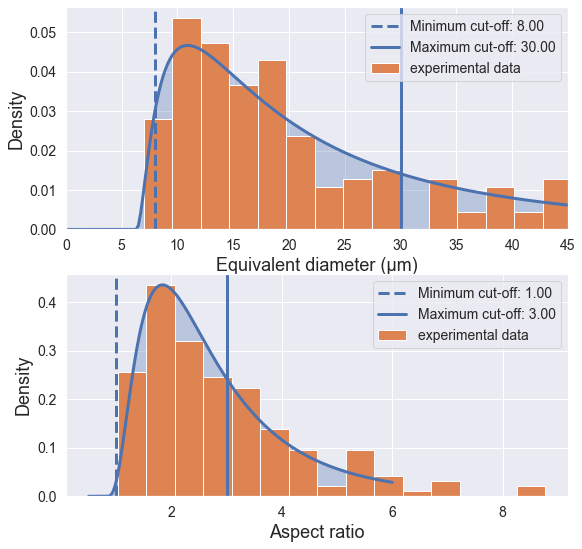

Creating an RVE based on user defined statistics
    Total number of grains        = 27
    RVE side lengths (X, Y, Z)    = 60, 60, 60
    Number of voxels (X, Y, Z)    = 30, 30, 30
    Voxel resolution (X, Y, Z)    = 2.0000, 2.0000, 2.0000
    Total number of voxels (C3D8) = 27000

Starting particle simulation
    Creating simulation box of required dimensions
    Creating particles from distribution statistics
    Particle packing by growth simulation


 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 701/1001 [00:44<00:18, 15.86it/s]


Completed particle packing
0 overlapping particles detected after packing
Kinetic energy of particles after packing: 6.275428580122706
Initial kinetic energy: 6.275428580122706



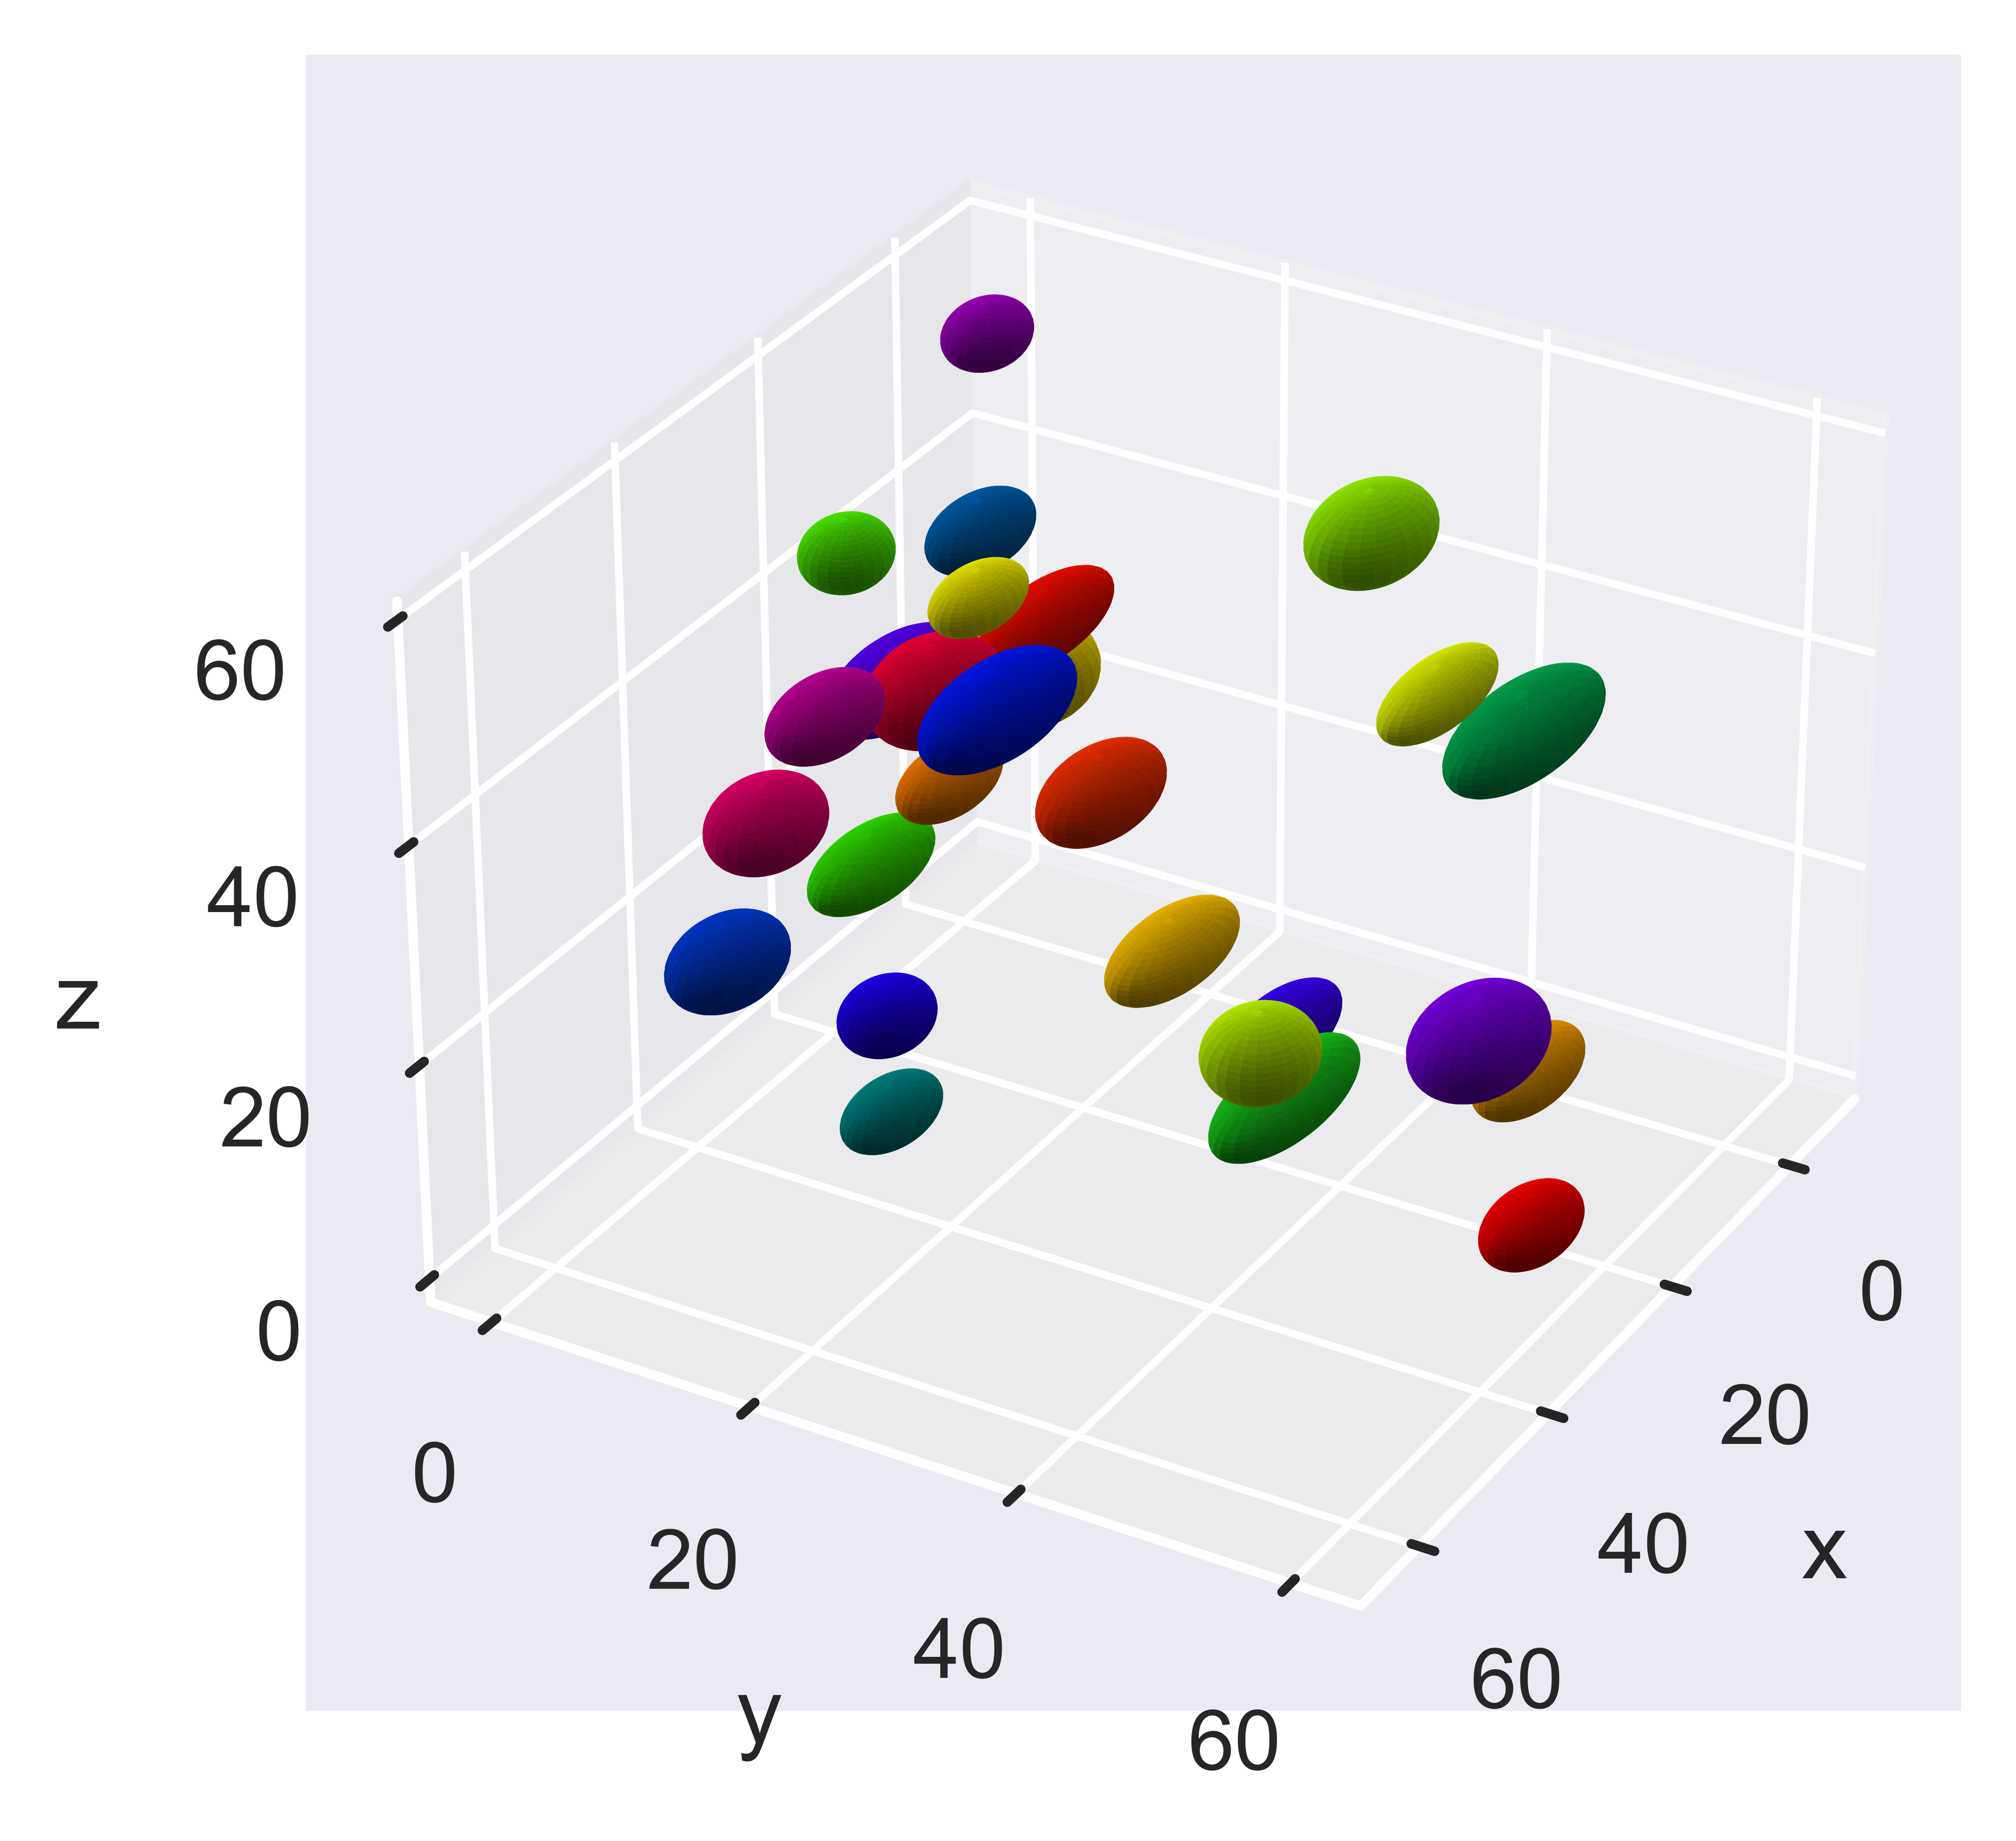


Starting RVE voxelization
    Generating voxels inside RVE
### create voxels 29791 (29791, 3)
    Assigning voxels to grains


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 23583133.69it/s]


Completed RVE voxelization


Generated Delaunay tesselation of grain vertices.
Assigning 671 tetrahedra to grains ...


671it [01:21,  8.23it/s] 


Finished generating polyhedral hulls for grains.
Mean absolute error of polyhedral vs. voxel volume of grains: 0.1625910825749696

Computing the L1-error between input and output diameter distributions
    L1 error between particle and grain geometries: 1.92593

Plotting input & output statistics


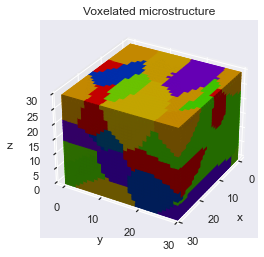

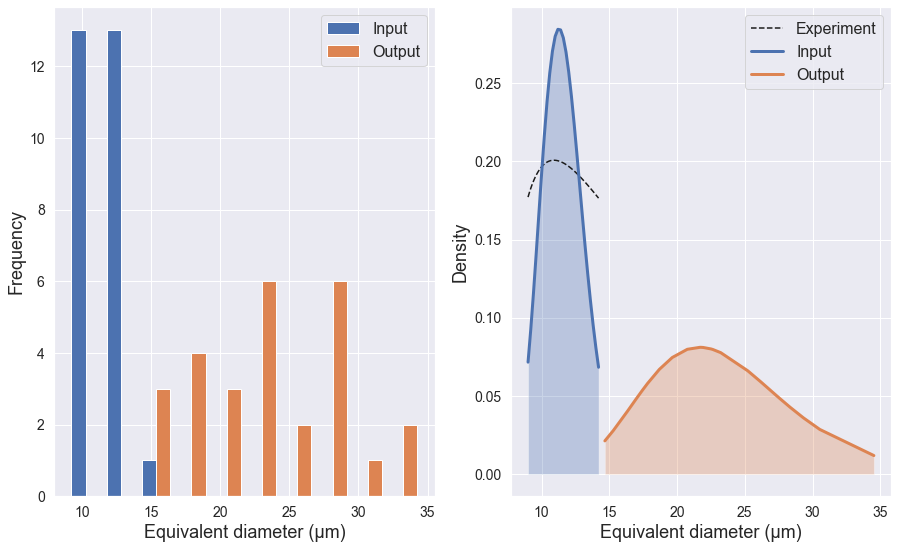

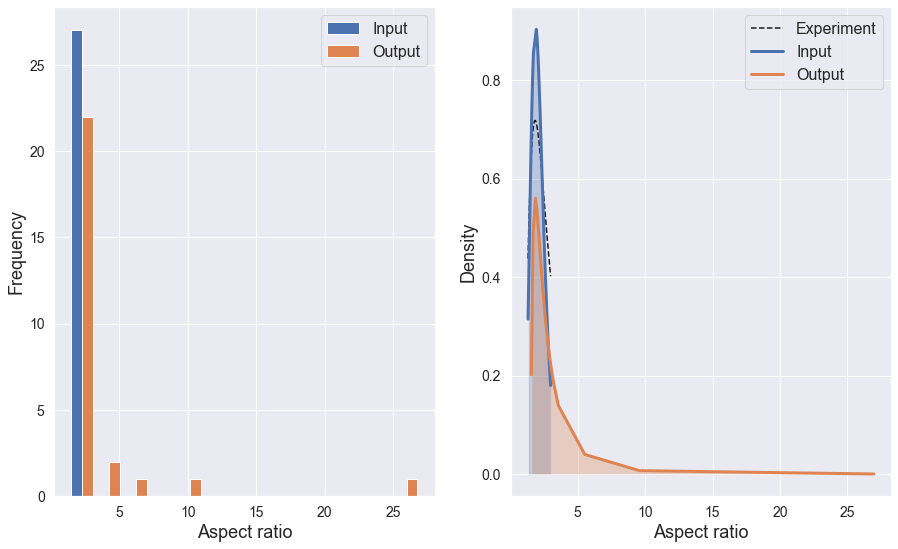

---->DONE!



In [3]:
# create dictionary with statistical information obtained from EBSD map
# gs_param : [std deviation, mean grain size, offset of lognorm distrib.]
# ar_param : [std deviation, mean aspect ration, offset of gamma distrib.]
# om_param : [std deviation, mean tilt angle]
Nv = 30
size = 60
periodic = True
ms_stats = knpy.set_stats(ebsd.gs_param, ebsd.ar_param, ebsd.om_param,
                          deq_min=8., deq_max=30., asp_min=1., asp_max=3.,
                          omega_min=0., omega_max=2*pi, voxels=Nv, size=size,
                          periodicity=periodic, VF = 1.0, phasename = "XXXX", phasenum = 0)

# create and visualize synthetic RVE
ms = knpy.Microstructure(descriptor=ms_stats, name=fname+'_RVE')
ms.init_stats(gs_data=ebsd.gs_data, ar_data=ebsd.ar_data)
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()
ms.voxelize()
ms.plot_voxels(sliced=False)
ms.generate_grains()
ms.plot_stats(gs_param=ebsd.gs_param, ar_param=ebsd.ar_param)


In [4]:
# get list of orientations for grains in RVE matching the ODF of the EBSD map
ori_rve = ebsd.calcORI(ms.Ngr, ms.shared_area)

# write Abaqus input file for voxelated structure
ptag = 'pbc' if periodic else 'non-pbc'
ms.output_abq('v', name=f'from_ebsd_vox{Nv}_gr{ms.Ngr}_{ptag}.inp')
# write Euler angles of grains into Abaqus input file
knpy.writeAbaqusMat(matnumber, ori_rve)
!mv Material.inp 'from_ebsd_mat{matnumber}_gr{ms.Ngr}.inp'

Optimum kernel estimated from mean orientations of grains
 estimating optimal kernel halfwidth: 0%
 estimate optimal kernel halfwidth: 10%
 estimate optimal kernel halfwidth: 20%
 estimate optimal kernel halfwidth: 30%
 estimate optimal kernel halfwidth: 40%
 estimate optimal kernel halfwidth: 50%
 estimate optimal kernel halfwidth: 60%
 estimate optimal kernel halfwidth: 70%
 estimate optimal kernel halfwidth: 80%
 estimate optimal kernel halfwidth: 90%
 estimate optimal kernel halfwidth: 100%

time =

   32.1158


e =

    0.2346


e =

    0.2263


e =

    0.2061


e =

    0.1785


e =

    0.1637


e =

    0.1531


e =

    0.1497


e =

    0.1461


e =

    0.1411


e =

    0.1368


e =

    0.1279


e =

    0.1129


e =

    0.1003


e =

    0.0913


e =

    0.0876


e =

    0.0803


e =

    0.0783


e =

    0.0752


e =

    0.0559


e =

    0.0289


time =

    2.0554


Writing ABAQUS (.inp) file---->DONE!

mv: rename Material.inp to from_ebsd_mat4_gr27.inp: No suc